In [1]:
import os
directory = os.getcwd()  
directory = directory.split('src')
path = directory[0]
%cd $path
%pwd

c:\Users\JENMOSQU\Documents\PERSONAL\cod\Probabilistic-Electricity-Demand-


'c:\\Users\\JENMOSQU\\Documents\\PERSONAL\\cod\\Probabilistic-Electricity-Demand-'

In [2]:
# Libraries..

import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from itertools import product
from tqdm import tqdm_notebook
import pandas as pd

#tensorflow
#from tensorflow.keras.models import load_model


# Plotly and Matplotlib
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px


#skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
# from skforecast.plot import plot_prediction_distribution

#sklearn
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import QuantileRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.utils import resample

#tsmoothie
from tsmoothie.smoother import ConvolutionSmoother
from tsmoothie.bootstrap import BootstrappingWrapper

# Modules from repo
from src.Utilities import utilities as tool


# tensorflow
from tensorflow.keras.models import load_model

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
# Configuración options.display
# ==============================================================================
pd.set_option('display.max_rows', 5000)
pd.options.display.max_rows = None
pd.options.display.max_columns = 5000
pd.options.display.max_colwidth = 5000
pd.options.display.max_dir_items = 5000
pd.options.display.width = 5000
pd.options.display.float_format = '{:.3f}'.format


c:\Users\JENMOSQU\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tensorflow WARNING From c:\Users\JENMOSQU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



Using TensorFlow backend


In [4]:
#Import Data..............

df=pd.read_parquet('df.parquet')
columnas_indeseadas =['HR_CAL_MEDIA_D', 'VVAG_MEDIA_D'] #columna con correlación 0 con la demanda
columnas_indeseadas += [f'Demanda_SIN_{i}' for i in range(1, 29)]
# columnas_indeseadas += [f'Demanda_SIN_{i}' for i in range(7, 29, 7)]
print("columnas rezagadas que no son necesarias porque skforecast rezaga internamente",columnas_indeseadas)
df = df.loc[:, ~df.columns.isin(columnas_indeseadas)]
print(df.head(1))
print("--------------------------------------------------------------------------------------------------")
print(df.tail(1))

columnas rezagadas que no son necesarias porque skforecast rezaga internamente ['HR_CAL_MEDIA_D', 'VVAG_MEDIA_D', 'Demanda_SIN_1', 'Demanda_SIN_2', 'Demanda_SIN_3', 'Demanda_SIN_4', 'Demanda_SIN_5', 'Demanda_SIN_6', 'Demanda_SIN_7', 'Demanda_SIN_8', 'Demanda_SIN_9', 'Demanda_SIN_10', 'Demanda_SIN_11', 'Demanda_SIN_12', 'Demanda_SIN_13', 'Demanda_SIN_14', 'Demanda_SIN_15', 'Demanda_SIN_16', 'Demanda_SIN_17', 'Demanda_SIN_18', 'Demanda_SIN_19', 'Demanda_SIN_20', 'Demanda_SIN_21', 'Demanda_SIN_22', 'Demanda_SIN_23', 'Demanda_SIN_24', 'Demanda_SIN_25', 'Demanda_SIN_26', 'Demanda_SIN_27', 'Demanda_SIN_28']
       FECHA TIPO_DIA  Demanda_SIN  Covid  Cambio_nivel  Tiempo  precipitacion  Temperatura  HRA2_MN_D  HRA2_MX_D  THSM_MEDIA_D  THSM_MX_D  VV_10_MEDIA_D  VV_10_VECT_MEDIA_D  THSM_MN_D  PT_2_TT_D  PT_2_MX_D  PT_10_MX_D  PT_10_TT_D  TSSM_MEDIA_D  TSSM_MN_D  TSSM_MX_D  PTPG_TT_D  BSHG_TT_D  TPR_CAL
0 2017-12-01  VIERNES   193865.750      0             0       1          9.589       22.203  

In [5]:
#Correlación variables y filtrado........
#['THSM_MEDIA_D','PTPG_TT_D']
correlacion_con_demanda = df.corr()['Demanda_SIN']
nombres_variables = correlacion_con_demanda[(correlacion_con_demanda >= 0.2) | (correlacion_con_demanda <= -0.2)]
print(nombres_variables)
nombres_variables=nombres_variables.index.tolist()
nombres_variables +=['THSM_MEDIA_D'] #'PTPG_TT_D' #'VVAG_MEDIA_D'
nombres_variables.remove('Demanda_SIN')
df=df[['FECHA', 'TIPO_DIA', 'Demanda_SIN'] + nombres_variables]
print("columnas finales", df.columns)

Demanda_SIN           1.000
Covid                -0.246
Cambio_nivel          0.352
Tiempo                0.595
VV_10_MEDIA_D         0.213
VV_10_VECT_MEDIA_D    0.210
PT_10_TT_D           -0.291
Name: Demanda_SIN, dtype: float64
columnas finales Index(['FECHA', 'TIPO_DIA', 'Demanda_SIN', 'Covid', 'Cambio_nivel', 'Tiempo', 'VV_10_MEDIA_D', 'VV_10_VECT_MEDIA_D', 'PT_10_TT_D', 'THSM_MEDIA_D'], dtype='object')


In [6]:
#Rolling mean.........
columns_rolling = ['VV_10_MEDIA_D', 'VV_10_VECT_MEDIA_D','PT_10_TT_D' ,'THSM_MEDIA_D']
window_size=60
df = tool.exploratory_tools.fill_null_values_with_rolling_mean(df, columns_rolling, window_size)

In [7]:
# Transformer one hot encoding and formatting-.......

print("--------------------------------------------------------------------------------------------------------------------------------------")
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      #(StandardScaler(), ['Demanda_SIN']),
                      (   
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          ['TIPO_DIA'],
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

df = one_hot_encoder.fit_transform(df)

#-------------------------------------------------------------------------------------------------------------------------------------------
#Variable TIPO_DIA
#-------------------------------------------------------------------------------------------------------------------------------------------
columnas_tipo_dia = [col for col in df.columns if col.startswith('TIPO_DIA_')]
variables_exogenas = ['FECHA'] + nombres_variables + columnas_tipo_dia
variable_dependiente = ['Demanda_SIN']
df = df[variable_dependiente + variables_exogenas] 

#-------------------------------------------------------------------------------------------------------------------------------------------
# Codificación de Fecha...
#-------------------------------------------------------------------------------------------------------------------------------------------
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d')
df = df.set_index('FECHA')
df = df.asfreq('D')

--------------------------------------------------------------------------------------------------------------------------------------


In [8]:
# Separación datos train-val-test................
#-------------------------------------------------------------------------------------------------------------------------------------------

datos = df[df.index >= '2017-12-01']
fin_train = '2023-05-31'
fin_validacion = '2023-09-23'

datos_train = datos[datos.index <= fin_train].copy()
datos_val = datos[(datos.index > fin_train) & (datos.index <= fin_validacion)].copy()
datos_test = datos[datos.index > fin_validacion].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
print("-------------------------------------------------------------------------------------------------------------------------------------")


Fechas train      : 2017-12-01 00:00:00 --- 2023-05-31 00:00:00  (n=2008)
Fechas validacion : 2023-06-01 00:00:00 --- 2023-09-23 00:00:00  (n=115)
Fechas test       : 2023-09-24 00:00:00 --- 2023-09-30 00:00:00  (n=7)
-------------------------------------------------------------------------------------------------------------------------------------


## Quantile Regressor 

In [12]:
# # Models to compare QuantileRegressor.............
# import random
# random.seed(123)

# models = [
#           QuantileRegressor(),
#           ]

# # Hyperparameter to search for each model
# param_grids = {
#                 'QuantileRegressor': {'alpha': np.logspace(-10, 5, 600)}
#                }


# # Lags used as predictors
# lags_grid = [6, 7 ,14, 21, 28]

# columnas_tipo_dia = [col for col in df.columns if col.startswith('TIPO_DIA_')]
# variables_exogenas = nombres_variables + columnas_tipo_dia

# df_results = pd.DataFrame()
# for i, model in enumerate(models):
#     print(f"-------------------------")
#     print(f"Grid search for regressor: {model}")
#     print(f"-------------------------")

#     forecaster = ForecasterAutoreg(
#                      regressor = model,
#                      lags      = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28],
#                      transformer_y = StandardScaler()
#                  )

#     # Regressor hyperparameters
#     param_grid = param_grids[list(param_grids)[i]]

#     results_grid = grid_search_forecaster(
#                        forecaster         = forecaster,
#                        y                  = datos.loc[:fin_validacion, 'Demanda_SIN'],
#                        exog               = datos.loc[:fin_validacion, variables_exogenas],
#                        param_grid         = param_grid,
#                        lags_grid          = lags_grid,
#                        steps              = len(datos.loc[:fin_validacion]),
#                        refit              = True, #True
#                        metric             = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
#                        initial_train_size = len(datos.loc[:fin_train]),
#                        fixed_train_size   = True, # False
#                        allow_incomplete_fold =True,
#                        return_best        = True, #True
#                        n_jobs             = 'auto',
#                        verbose            = False, #True
#                        show_progress      = True
#                    )
    
#     # Create a column with model name
#     results_grid['model'] = list(param_grids)[i]
    
#     df_results = pd.concat([df_results, results_grid])

# df_results = df_results.sort_values(by='mean_squared_error')



# # Backtesting datos de test
# # ==============================================================================
# metric, predicciones = backtesting_forecaster(
#                             forecaster         = forecaster,
#                             y                    = datos.loc[:fin_validacion, 'Demanda_SIN'],
#                             exog                 = datos.loc[:fin_validacion, variables_exogenas],
#                             initial_train_size = len(datos.loc[:fin_train]),
#                             fixed_train_size   = False,
#                             allow_incomplete_fold =True,
#                             steps              = 7, #len(datos.loc[:fin_validacion])
#                             metric             = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
#                             refit              = True, #7
#                             interval           = [2.5, 97.5],
#                             random_state	  = 123,
#                             n_jobs             = 'auto',
#                             verbose            = True,
#                             show_progress      = True,
#                        )
# print(metric)
# print(f"Error de backtest_mean_squared_error: {metric[0]:.4f}")
# print(f"Error de backtest_mean_absolute_error: {metric[1]:.4f}")
# print(f"Error de backtest_mean_absolute_percentage_error: {metric[2]:.4f}")
# predicciones
# y_true = datos.loc[predicciones.index, 'Demanda_SIN']
# mae = mean_absolute_error(y_true, predicciones['pred'])
# mape = (mae / y_true).mean() * 100
# print("MAPE:", mape)

# #Grafico de predicciones vs real........

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=datos.loc[predicciones.index, 'Demanda_SIN'].index,
#                          y=datos.loc[predicciones.index, 'Demanda_SIN'],
#                          mode='lines',
#                          name='test',
#                          line=dict(color='#bc8f8f'))) 
# fig.add_trace(go.Scatter(x=predicciones.index,
#                          y=predicciones['pred'],
#                          mode='lines',
#                          name='predicción',
#                          line=dict(color='#276981'))) 
# fig.update_layout(title='Predicción vs demanda real')
# fig.update_layout(legend=dict(title='Series', orientation='h', y=1.02, xanchor='right', x=1))
# fig.show()

### Prediction Intervals with Quantile Regression

In [9]:
from sklearn.linear_model import QuantileRegressor

In [11]:
# Create forecasters: one for each bound of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).
#.........................................................
#variables_exogenas.remove('FECHA') 
#.........................................................
from sklearn.utils.fixes import sp_version, parse_version
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
# Forecaster for quantile 10%
forecaster_q10 = ForecasterAutoregDirect(
                     regressor = QuantileRegressor(quantile=0.1,alpha = 0.1, solver = solver),
                     lags = 28,
                     steps = len(datos.loc[fin_train:fin_validacion]),
                     transformer_y = StandardScaler()
                 )
                  
# Forecaster for quantile 90%
forecaster_q90 = ForecasterAutoregDirect(
                     regressor = QuantileRegressor(quantile=0.9,alpha = 0.1, solver = solver),
                     lags = 28,
                     steps = len(datos.loc[fin_train:fin_validacion]),
                     transformer_y = StandardScaler()
                 )

forecaster_q10.fit(y=datos_train['Demanda_SIN'], exog=datos_train[variables_exogenas])
forecaster_q90.fit(y=datos_train['Demanda_SIN'], exog=datos_train[variables_exogenas])

In [12]:
# Predict intervals for next len(datos_val) steps.............
# ==============================================================================
predictions_q10 = forecaster_q10.predict(steps=len(datos_val), exog=datos_val[variables_exogenas])
predictions_q90 = forecaster_q90.predict(steps=len(datos_val), exog=datos_val[variables_exogenas])
predictions = pd.DataFrame({
                  'lower_bound': predictions_q10,
                  'upper_bound': predictions_q90,
              })
predictions.head()

,lower_bound,upper_bound
2023-06-01,197898.134,224172.296
2023-06-02,197646.533,224118.551
2023-06-03,195706.544,224131.138
2023-06-04,191540.570,224143.725
2023-06-05,196619.015,224222.812


In [13]:
from skforecast.exceptions import LongTrainingWarning

In [14]:
# Backtesting on test data..........
# ==============================================================================
warnings.simplefilter('ignore', category=LongTrainingWarning)
metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster         = forecaster_q10,
                                  y                  = datos['Demanda_SIN'],
                                  initial_train_size = len(datos_train) + len(datos_val),
                                  steps              = len(datos.loc[fin_train:fin_validacion]),
                                  refit              = True,
                                  metric             = tool.Prediction_intervals_tools.mean_pinball_loss_q10,
                                  verbose            = False,
                                  show_progress      = True
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster         = forecaster_q90,
                                  y                  = datos['Demanda_SIN'],
                                  initial_train_size = len(datos_train) + len(datos_val),
                                  steps              = len(datos.loc[fin_train:fin_validacion]),
                                  refit              = True,
                                  metric             = tool.Prediction_intervals_tools.mean_pinball_loss_q90,
                                  verbose            = False,
                                  show_progress      = True
                              )

print("Quantile 10 metric", metric_q10)
print("Quantile 90 metric", metric_q90)

print("")
display(predictions_q10.head(4))
print("")
display(predictions_q90.head(4))

100%|██████████| 1/1 [00:00<00:00, 281.03it/s]

Quantile 10 metric 3236.4384717833345
Quantile 90 metric 7758.574578443515



,pred
2023-09-24,190673.286
2023-09-25,196737.183
2023-09-26,199397.075
2023-09-27,200493.837


,pred
2023-09-24,212578.893
2023-09-25,222848.539
2023-09-26,225621.481
2023-09-27,226473.616


In [15]:
# Interval coverage on test data............
# ==============================================================================
inside_interval = np.where(
                      (datos_test.loc[fin_validacion:, 'Demanda_SIN'] >= predictions_q10['pred']) & \
                      (datos_test.loc[fin_validacion:, 'Demanda_SIN'] <= predictions_q90['pred']),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval: {100 * coverage}")

Coverage of the predicted interval: 14.285714285714285


In [21]:
# Grid search of hyper-parameters and lags for each quantile forecaster
# ==============================================================================
# Regressor hyper-parameters

from sklearn.utils.fixes import sp_version, parse_version
solver = ['highs', 'revised simplex'] 

param_grid = {
    'alpha': np.logspace(-10, 5, 5),
    'solver': solver,
}

# Lags used as predictors

lags_grid = [6, 7 ,14, 21, 28]

results_grid_q10 = grid_search_forecaster(
                       forecaster         = forecaster_q10,
                       y                  = datos.loc[:fin_validacion, 'Demanda_SIN'],
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = len(datos.loc[fin_train:fin_validacion]),
                       refit              = True,
                       metric             = tool.Prediction_intervals_tools.mean_pinball_loss_q10,
                       initial_train_size = int(len(datos_train)),
                       return_best        = True,
                       verbose            = False,
                       show_progress      = True
                   )

Number of models compared: 50.


lags grid:   0%|          | 0/5 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Regressor hyper-parameters
from sklearn.utils.fixes import sp_version, parse_version
solver = ['highs-ds', 'highs-ipm', 'highs', 'revised simplex'] if sp_version >= parse_version("1.6.0") else "interior-point"

param_grid = {
    'alpha': np.logspace(-10, 5, 100),
    'solver': solver,
}

# Lags used as predictors

lags_grid = [6, 7 ,14, 21, 28]


results_grid_q90 = grid_search_forecaster(
                       forecaster         = forecaster_q90,
                       y                  = datos.loc[:fin_validacion, 'Demanda_SIN'],
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = len(datos.loc[fin_train:fin_validacion]),
                       refit              = True,
                       metric             = tool.Prediction_intervals_tools.mean_pinball_loss_q90,
                       initial_train_size = int(len(datos_train)),
                       return_best        = True,
                       verbose            = False,
                       show_progress      = True
                   )


Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

lags grid: 100%|██████████| 4/4 [2:41:15<00:00, 2418.89s/it]  


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 6905.180666017886



In [36]:
# Backtesting on test data............
# ==============================================================================
metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster         = forecaster_q10,
                                  y                  = datos['Demanda_SIN'],
                                  initial_train_size = len(datos_train) + len(datos_val),
                                  steps              = len(datos.loc[fin_train:fin_validacion]),
                                  refit              = False,
                                  metric             = tool.Prediction_intervals_tools.mean_pinball_loss_q10,
                                  verbose            = False
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster         = forecaster_q90,
                                  y                  = datos['Demanda_SIN'],
                                  initial_train_size = len(datos_train) + len(datos_val),
                                  steps              = len(datos.loc[fin_train:fin_validacion]),
                                  refit              = False,
                                  metric             = tool.Prediction_intervals_tools.mean_pinball_loss_q90,
                                  verbose            = False
                              )

100%|██████████| 1/1 [00:00<00:00, 107.45it/s]


In [37]:
import plotly.graph_objects as go

fig = go.Figure()

# Agrega la serie 'Demanda Real' con el color #bc8f8f
fig.add_trace(go.Scatter(
    x=datos_test.loc[fin_validacion:].index,
    y=datos_test.loc[fin_validacion:, 'Demanda_SIN'],
    mode='lines',
    name='Demanda Real',
    line=dict(color='#bc8f8f')
))

# Agrega la banda de intervalo entre predictions_q10 y predictions_q90 con el color especificado
fig.add_trace(go.Scatter(
    x=datos_test.loc[fin_validacion:].index,
    y=predictions_q10,
    mode='lines',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(185, 203, 211, 0.8)',  # Cambio de color aquí
    name='80% interval'
))

# Agrega la banda de intervalo entre predictions_q10 y predictions_q90 con el color especificado
fig.add_trace(go.Scatter(
    x=datos_test.loc[fin_validacion:].index,
    y=predictions_q90,
    mode='lines',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(185, 203, 211, 0.8)',  # Cambio de color aquí
    name='90% interval'
))

# Estilo y diseño del gráfico
fig.update_layout(
    title='Energy demand forecast',
    yaxis_title='MW',
    xaxis_title='',
    yaxis_tickformat='SI',  # Formato de notación de ingeniería
)

# Mostrar el gráfico
fig.show()



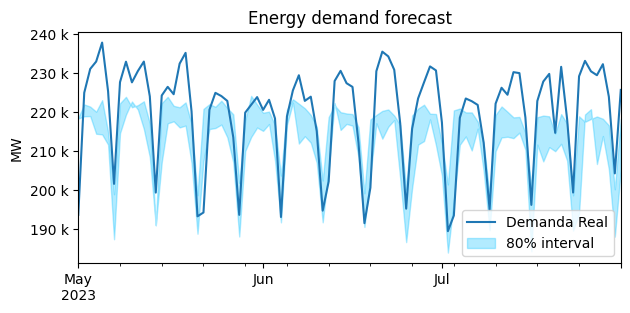

In [12]:

# # Plot
# # ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3))
# datos_test.loc[fin_validacion:, 'Demanda_SIN'].plot(ax=ax, label='Demanda Real')
# ax.fill_between(
#     datos_test.loc[fin_validacion:].index,
#     predictions_q10['pred'],
#     predictions_q90['pred'],
#     color = 'deepskyblue',
#     alpha = 0.3,
#     label = '80% interval'
# )
# ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.set_ylabel('MW')
# ax.set_xlabel('')
# ax.set_title('Energy demand forecast')
# ax.legend();

## INTERVALS FOR RNN's

In [6]:
#Split....

#DATOS DE ENTRENAMIENTO
X_train = datos_train.drop("Demanda_SIN", axis=1)
y_train = datos_train["Demanda_SIN"]
X_train = X_train.values
X_train = X_train.reshape((X_train.shape[0],1,  X_train.shape[1]))


# DATOS DE VALIDACIÓN
X_val = datos_val.drop("Demanda_SIN", axis=1)
y_val = datos_val["Demanda_SIN"]
X_val=X_val.values
X_val = X_val.reshape((X_val.shape[0],1,  X_val.shape[1]))


# DATOS DE TEST
X_test = datos_test.drop("Demanda_SIN", axis=1)
y_test = datos_test["Demanda_SIN"]
X_test=X_test.values
X_test = X_test.reshape((X_test.shape[0],1,  X_test.shape[1]))

In [7]:
#DL Models......

rnn  = load_model("Rnn_models/rnn.h5")
lstm = load_model("Rnn_models/lstm.h5")
gru = load_model("Rnn_models/gru.h5")
bidirectional_lstm = load_model("Rnn_models/bidirectional_lstm.h5")

In [52]:
# Z-score...
y_pred = lstm.predict(X_test)
y_pred = y_pred.ravel()
y_test = y_test.ravel()
error_std = np.std(y_pred - y_test, ddof=1)
confidence_level = 0.95  
z_score = 1.96 

lower_bound = y_pred - z_score * error_std
upper_bound = y_pred + z_score * error_std

3/3 [==============================] - 1s 3ms/step


In [56]:
# Gráfico: Intervalos con Z-score...
# ==============================================================================

datos_test['predictions'] = y_pred
datos_test['lower_bound'] = lower_bound
datos_test['upper_bound'] = upper_bound

fig = go.Figure()
# Agrega las series de datos
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['Demanda_SIN'], mode='lines', name='Real Data'))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['predictions'], mode='lines', name='Predictions', line=dict(color='#aa6073')))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['lower_bound'], fill='tonexty', mode='lines', line_color='#8c9a70', fillcolor='rgba(200, 200, 200, 0.5)', showlegend=False))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['upper_bound'], fill='tonexty', mode='lines', line_color='#8c9a70', fillcolor='rgba(200, 200, 200, 0.5)', name='Prediction Interval'))

# Estilo y diseño del gráfico
fig.update_layout(
    title='Energy Demand Forecast with Prediction Interval',
    yaxis_title='MW',
    xaxis_title='',
    showlegend=True
)
# Mostrar el gráfico
fig.show()

In [8]:
models = [("RNN", rnn), ("LSTM", lstm),  ("GRU", gru), ("BidirectionalLSTM", bidirectional_lstm)] 
 
test = pd.concat(objs=[pd.Series(model.predict(X_test, verbose=0).ravel(),
                                 name=f"{name}_forecast",
                                 index=y_test.index) for name, model in models], axis=1).join(y_test)
test.head(2)

,RNN_forecast,LSTM_forecast,GRU_forecast,BidirectionalLSTM_forecast,Demanda_SIN
FECHA,,,,,
2023-05-01,209698.937500,215910.453125,215340.56250,212685.828125,193723.32409
2023-05-02,209698.984375,230195.187500,227129.46875,229992.609375,224984.32801


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Intervalos de Predicción con el Método Bootstrap
best_forecast = test[['Demanda_SIN' ,'GRU_forecast', 'BidirectionalLSTM_forecast']]

df = test["BidirectionalLSTM_forecast"].T

bts = BootstrappingWrapper(ConvolutionSmoother(window_len=3, window_type="ones"),
                           bootstrap_type="mbb", block_length=10)

bts_samples = bts.sample(data=df, n_samples=10000)

means = [np.mean(bts_samples[:, i]) for i in range(bts_samples.shape[1])]
std = [np.std(bts_samples[:, i]) for i in range(bts_samples.shape[1])]

best_forecast["LI"] = [m - 3 * s for m, s in zip(means, std)]
best_forecast["LS"] = [m + 3 * s for m, s in zip(means, std)]

# Crear un gráfico de líneas con intervalos de predicción
fig = px.line(best_forecast, x=best_forecast.index, y=['Demanda_SIN', 'GRU_forecast', 'BidirectionalLSTM_forecast'],
              labels={'value': 'Valor', 'index': 'Fecha'},
              color_discrete_sequence=color_discrete_sequence)

# Añadir las bandas de intervalo de predicción
fig.add_trace(go.Scatter(x=best_forecast.index.append(best_forecast.index[::-1]),
                         y=best_forecast['LI'].append(best_forecast['LS'][::-1]),
                         fill='toself',
                         fillcolor='rgba(0,100,80,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name='Intervalo de Predicción'))

# Personalizar el gráfico
fig.update_layout(
    title="Intervalos de Predicción con Bootstrap",
    xaxis_title="Fecha",
    yaxis_title="Valor",
)

# Mostrar el gráfico
fig.show()


In [9]:
# Intervalos de Predcción con el Método Boostrap...

best_forecast = test[['Demanda_SIN' ,'GRU_forecast', 'BidirectionalLSTM_forecast']]

df = test["BidirectionalLSTM_forecast"].T

bts = BootstrappingWrapper(ConvolutionSmoother(window_len=3, window_type="ones"),
                           bootstrap_type="mbb", block_length=10)

bts_samples = bts.sample(data=df, n_samples=10000)

means = [np.mean(bts_samples[:, i]) for i in range(bts_samples.shape[1])]
std = [np.std(bts_samples[:, i]) for i in range(bts_samples.shape[1])]

best_forecast["LI"] = [m - 3 * s for m, s in zip(means, std)]
best_forecast["LS"] = [m + 3 * s for m, s in zip(means, std)]

C:\Users\JENMOSQU\AppData\Local\Temp\ipykernel_9364\3798304221.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_forecast["LI"] = [m - 3 * s for m, s in zip(means, std)]


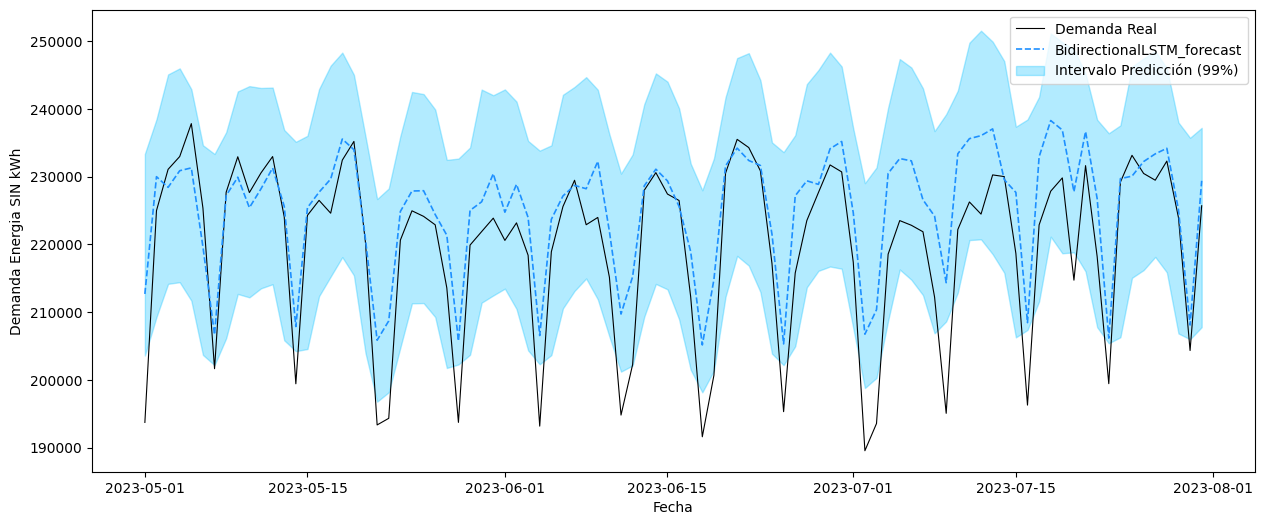

In [10]:
#Grafica con Método Boostrap....

# plt.figure(figsize=(15, 6))
# plt.plot(best_forecast.index, best_forecast['Demanda_SIN'], color = 'black', linewidth=0.8, label = 'Demanda Real')
# plt.plot(best_forecast.index, best_forecast['BidirectionalLSTM_forecast'], color = 'dodgerblue', linewidth=1.2, linestyle = 'dashed', label = 'BidirectionalLSTM_forecast')
# plt.fill_between(best_forecast.index, best_forecast['LI'], best_forecast['LS'], color = 'deepskyblue', alpha = 0.3, label = 'Intervalo Predicción (99%)')
# plt.xlabel('Fecha')
# plt.ylabel('Demanda Energia SIN kWh')
# plt.legend()


fig = go.Figure()

# Agregar la línea de 'Demanda Real'
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['Demanda_SIN'], mode='lines', name='Demanda Real', line=dict(color='black', width=0.8)))

# Agregar la línea de 'BidirectionalLSTM_forecast'
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['BidirectionalLSTM_forecast'], mode='lines', name='BidirectionalLSTM_forecast', line=dict(color='dodgerblue', width=1.2, dash='dash')))

# Agregar el relleno del intervalo del 99%
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['LS'], fill=None, mode='lines', line=dict(color='deepskyblue', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['LI'], fill='tonexty', mode='lines', line=dict(color='deepskyblue', width=0), fillcolor='deepskyblue', opacity=0.3, name='Intervalo Predicción (99%)'))

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Demanda Energía SIN kWh',
    title='Grafica con Método Boostrap',
)

fig.show()


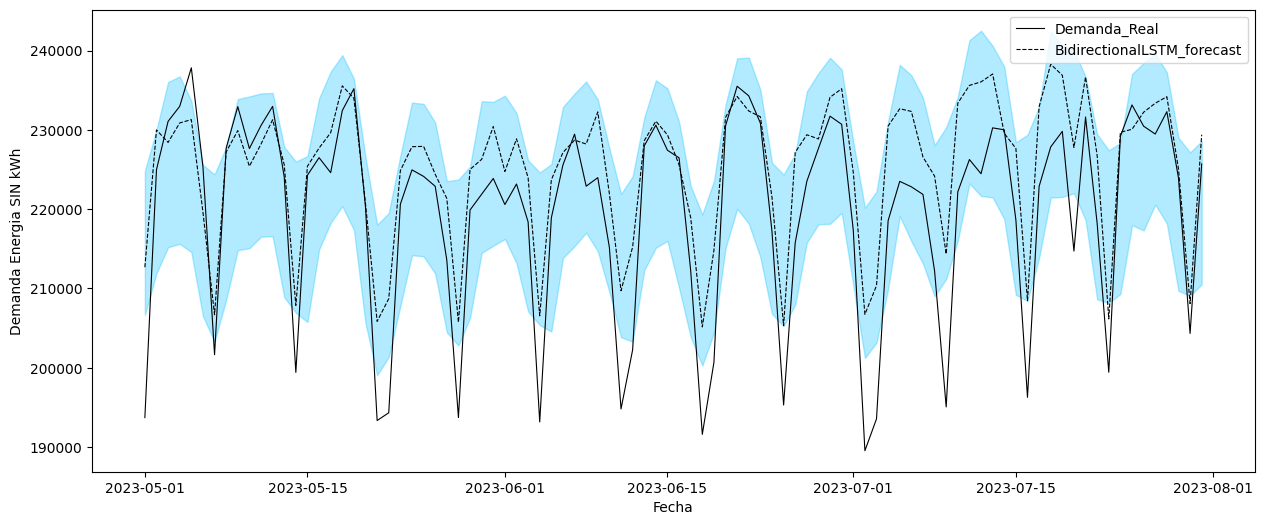

In [11]:

# best_forecast["LI"] = [np.quantile(bts_samples[:, i], q=0.025) for i in range(bts_samples.shape[1])]
# best_forecast["LS"] = [np.quantile(bts_samples[:, i], q=0.975) for i in range(bts_samples.shape[1])]

# plt.figure(figsize=(15, 6))
# plt.plot(best_forecast.index, best_forecast['Demanda_SIN'], color = 'black', linewidth=0.8, label = 'Demanda_Real')
# plt.plot(best_forecast.index, best_forecast['BidirectionalLSTM_forecast'], color = 'black', linewidth=0.8, linestyle = 'dashed', label = 'BidirectionalLSTM_forecast')
# plt.fill_between(best_forecast.index, best_forecast['LI'], best_forecast['LS'], color = 'deepskyblue', alpha = 0.3)
# plt.xlabel('Fecha')
# plt.ylabel('Demanda Energia SIN kWh')
# plt.legend()

fig = go.Figure()

# Agregar la línea de 'Demanda_Real'
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['Demanda_SIN'], mode='lines', name='Demanda_Real', line=dict(color='black', width=0.8)))

# Agregar la línea de 'BidirectionalLSTM_forecast'
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['BidirectionalLSTM_forecast'], mode='lines', name='BidirectionalLSTM_forecast', line=dict(color='black', width=0.8, dash='dash')))

# Agregar el relleno del intervalo del 95%
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['LS'], fill=None, mode='lines', line=dict(color='deepskyblue', width=0), showlegend=False))
fig.add_trace(go.Scatter(x=best_forecast.index, y=best_forecast['LI'], fill='tonexty', mode='lines', line=dict(color='deepskyblue', width=0), fillcolor='deepskyblue', opacity=0.3, name='Intervalo Predicción (95%)'))

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Demanda Energía SIN kWh',
    title='Gráfico con Método Bootstrap',
)

fig.show()


In [15]:
# 3. Realizar muestreo bootstrap y guardar predicciones...........Experimento..........

n_bootstrap = 1000  # Número de muestras bootstrap
predicciones_bootstrap = []

for _ in range(n_bootstrap):
    X_boot, y_boot = resample(X_test, y_test, replace=True, random_state=42)
    predicciones = bidirectional_lstm.predict(X_boot)  # Reemplaza con tu modelo
    predicciones_bootstrap.append(predicciones)

# 4. Calcular percentiles de las predicciones bootstrap
lower_percentile = 2.5  # Percentil inferior para intervalo del 95%
upper_percentile = 97.5  # Percentil superior para intervalo del 95%

lower_bound = np.percentile(predicciones_bootstrap, lower_percentile, axis=0)
upper_bound = np.percentile(predicciones_bootstrap, upper_percentile, axis=0)

# 5. Obtener intervalos de predicción
intervalo_prediccion = pd.DataFrame({'lower_bound': lower_bound.ravel(), 'upper_bound': upper_bound.ravel()})
intervalo_prediccion

3/3 [==============================] - 0s 3ms/step
